In [120]:
import numpy as np
import pandas as pd
import gym
from gym.envs.toy_text.frozen_lake import generate_random_map
from gym.envs.registration import register
from gym import wrappers
from hiive.mdptoolbox import mdp
from time import time
import matplotlib.pyplot as plt

In [85]:
# Define Problem
size = 6  # Set size here
frozenLake = generate_random_map(size=size, p=0.8)
env = gym.make("FrozenLake-v0", desc=frozenLake, is_slippery=True)

num_state = env.observation_space.n
num_action = env.action_space.n
# LEFT = 0
# DOWN = 1
# RIGHT = 2
# UP = 3

action_map = {0: "←", 1: "↓", 2: "→", 3: "↑"}

print('num_state: ',num_state )
print('num_action: ',num_action )

env.reset()
env.render(mode='human')

display(env.env.P[0][0])

num_state:  36
num_action:  4

SFFFFF
HHFFFH
FFFHFF
FFFFFF
FHFFFF
FFFFFG


[(0.3333333333333333, 0, 0.0, False),
 (0.3333333333333333, 0, 0.0, False),
 (0.3333333333333333, 6, 0.0, True)]

In [113]:
def plot_figure(V_optimized, policy_optimized, name ):
    fig = plt.figure(figsize=(size, size))
    plt.rcParams.update({'font.size': 15})
    ax = fig.add_subplot()
    
    V_plot = np.reshape(V_optimized, (size,size))
    im = ax.imshow(V_plot, cmap = 'Blues')

    if np.amax(V_optimized) > 0:
        for (j,i),value in np.ndenumerate(V_plot):
            ax.text(i, j, np.round(value, 2), ha='center',va='bottom')
            
    actions = [action_map[x] for x in policy_optimized]
    actions_plot = np.reshape(actions, (size,size))
    for (j,i),symbol in np.ndenumerate(actions_plot):
        ax.text(i, j, symbol, ha='center',va='top')

    plt.tick_params(bottom='off', left='off', labelbottom='off', labelleft='off')
    plt.title('Value Matrix\n' + name)
    plt.savefig('../plots/'+name+'.png')
    plt.show()

    

Converge at iteration 393
Runnning Time: 1.3862740993499756 seconds
Optimized Value:
[0.13430643 0.15551271 0.20127362 0.21021249 0.2273149  0.19631741
 0.         0.         0.2241148  0.22630153 0.28030913 0.
 0.24466674 0.25937017 0.28015579 0.         0.43157029 0.49949216
 0.26859491 0.29424116 0.40121753 0.49631864 0.58305225 0.64628122
 0.28535838 0.         0.47644291 0.58305225 0.69861778 0.81155458
 0.34717843 0.40199608 0.52028679 0.64628122 0.81155458 0.        ]
Optimized Policy:
[3. 3. 2. 2. 0. 3. 0. 0. 2. 3. 0. 0. 1. 1. 0. 0. 2. 1. 1. 3. 1. 1. 1. 1.
 0. 0. 2. 2. 1. 1. 1. 1. 2. 2. 2. 0.]


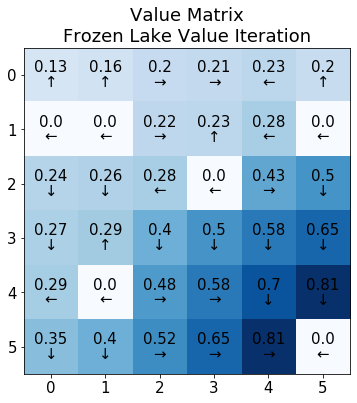

In [114]:
# Value Iteration
gamma = 0.95
def value_iteration(env, gamma=0.95):
    num_iter = 10000
    threshold = 1e-20
    V = np.zeros(num_state)
    for i in range(num_iter):
        V_curr = V.copy()
        
        for state in range(num_state):
            Q_value = []
            for action in range(num_action):
                next_states_rewards = []
                for trans_prob, next_state, reward, done in env.P[state][action]:
                    next_states_rewards.append(
                        (trans_prob*(reward+gamma*V_curr[next_state])))
                    Q_value.append(np.sum(next_states_rewards))
                    V[state] = max(Q_value)

        if(np.sum(np.fabs(V-V_curr)) <= threshold):
            print("Converge at iteration " + str(i+1))
            break
    return V

def get_policy(V, gamma=0.95):
    policy = np.zeros(num_state)
    for state in range(num_state):
        Q = np.zeros(num_action)
        for action in range(num_action):
            for trans_prob, next_state, reward, done in env.P[state][action]:
                Q[action] += (trans_prob * (reward+gamma*V[next_state]))
        policy[state] = np.argmax(Q)
    return policy

env.reset()
time_start = time()
V_optimized = value_iteration(env=env, gamma=gamma)
policy_optimized = get_policy(V_optimized, gamma=gamma)
print("Runnning Time:", time()-time_start, "seconds")
print("Optimized Value:")
print(V_optimized)
print("Optimized Policy:")
print(policy_optimized)

plot_figure(V_optimized, policy_optimized, 'Frozen Lake Value Iteration')




Converge at iteration 8
Runnning Time: 0.28304409980773926 seconds
Optimized Value:
[0.13430643 0.15551271 0.20127362 0.21021249 0.2273149  0.19631741
 0.         0.         0.2241148  0.22630153 0.28030913 0.
 0.24466674 0.25937017 0.28015579 0.         0.43157029 0.49949216
 0.26859491 0.29424116 0.40121753 0.49631864 0.58305225 0.64628122
 0.28535838 0.         0.47644291 0.58305225 0.69861778 0.81155458
 0.34717843 0.40199608 0.52028679 0.64628122 0.81155458 0.        ]
Optimized Policy:
[3. 3. 2. 2. 0. 3. 0. 0. 2. 3. 0. 0. 1. 1. 0. 0. 2. 1. 1. 3. 1. 1. 1. 1.
 0. 0. 2. 2. 1. 1. 1. 1. 2. 2. 2. 0.]


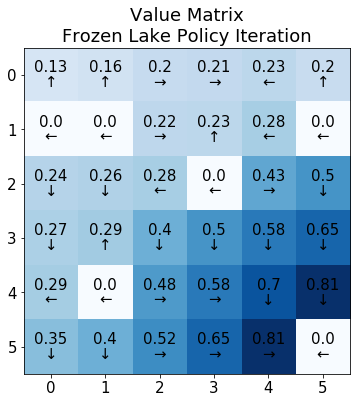

In [115]:
# Policy Iteration
gamma=0.95
def update_value(policy, gamma=0.95):
    V = np.zeros(num_state)
    threshold = 1e-10
    while True:
        V_curr = V.copy()
        for state in range(num_state):
            action = policy[state]
            V[state] = sum([trans_prob*(reward+gamma*V_curr[next_state])
                            for trans_prob, next_state, reward, done in env.P[state][action]])
        if (np.sum((np.fabs(V-V_curr))) <= threshold):
            break
    return V


def get_policy(V, gamma=0.95):
    policy = np.zeros(num_state)
    for state in range(num_state):
        Q = np.zeros(num_action)
        for action in range(num_action):
            for trans_prob, next_state, reward, done in env.P[state][action]:
                Q[action] += (trans_prob * (reward+gamma*V[next_state]))
        policy[state] = np.argmax(Q)
    return policy


def policy_iteration(env, gamma=0.95):
    policy = np.zeros(num_state)
    num_iter = 10000
    for i in range(num_iter):
        V_updated = update_value(policy, gamma)
        policy_updated = get_policy(V_updated, gamma)
        if (np.all(policy == policy_updated)):
            print('Converge at iteration ' + str(i+1))
            break
        policy = policy_updated
    return policy_updated, V_updated


env.reset()
time_start = time()
policy_optimized, V_optimized= policy_iteration(env, gamma = gamma)
print("Runnning Time:", time()-time_start, "seconds")
print("Optimized Value:")
print(V_optimized)
print("Optimized Policy:")
print(policy_optimized)

plot_figure(V_optimized, policy_optimized, 'Frozen Lake Policy Iteration')


In [160]:
# Q-Learning
env.reset()
Q = np.zeros([env.observation_space.n,env.action_space.n])
alpha = 0.8 # learning rate
gamma = 0.95 # discount factor
num_episodes = 2000
rewards = []
iterations = []
time_start = time()
Q_optimized = Q
reward_max = 0
for i in range(num_episodes):
    s = env.reset()
    reward = 0
    d = False
    j = 0
    while j < 200:
        j += 1
        a = np.argmax(Q[s,:] + np.random.randn(1, env.action_space.n) * (1./(i+1)))
        s1, r, d, _ = env.step(a)
        Q[s,a] = Q[s, a] + alpha*(r + gamma*np.max(Q[s1,:]) - Q[s,a])
        reward += r
        s = s1
        if d == True:
            break
    iterations.append(j)
    rewards.append(reward)
    if reward > reward_max:
        reward_max = reward
        Q_optimized = Q

print('Converge at iteration ' + str(i+1))
print("Runnning Time:", time()-time_start, "seconds")
print("Score over time："+ str(sum(rewards)/num_episodes))
print("Print Q Chart：")
print(Q_optimized)
print(reward_max)

Converge at iteration 2000
Runnning Time: 1.2542970180511475 seconds
Score over time：0.106
Print Q Chart：
[[2.40212321e-04 4.62855483e-04 7.33631809e-06 2.65956208e-02]
 [3.37026302e-04 5.11017696e-05 1.36859134e-04 3.90463885e-02]
 [0.00000000e+00 1.76468164e-03 4.31816408e-04 5.27990919e-02]
 [0.00000000e+00 6.45975783e-02 5.79259955e-05 0.00000000e+00]
 [4.74596257e-02 0.00000000e+00 7.97091908e-04 0.00000000e+00]
 [0.00000000e+00 1.43036893e-04 0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00]
 [2.19570755e-05 3.86512884e-05 1.19638080e-01 2.79739710e-06]
 [0.00000000e+00 6.90265371e-05 0.00000000e+00 5.21023813e-02]
 [1.94304527e-01 0.00000000e+00 0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00]
 [1.81871035e-05 1.38396067e-02 3.33123707e-04 0.00000000e+00]
 [0.00000000e+00 1.39209953e-02 9.13126591e-05 0.00000000e+00]
 [3.77041626

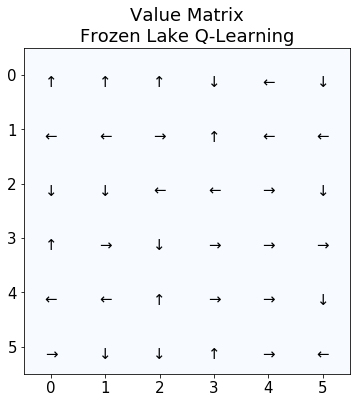

In [161]:
policy_optimized = Q_optimized.argmax(axis = 1)
plot_figure(policy_optimized*0, policy_optimized, 'Frozen Lake Q-Learning')


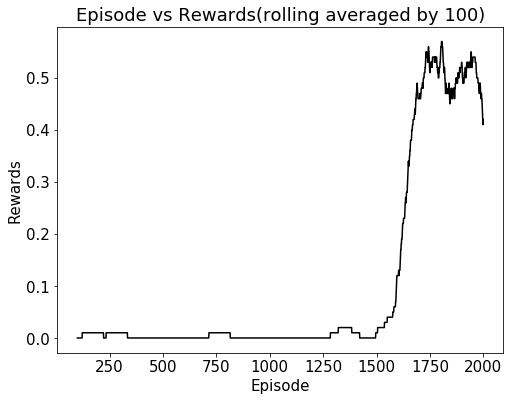

In [162]:
plt.figure(figsize=(8,6))
plt.plot(pd.Series(rewards).rolling(100, min_periods=100).mean(),'k')
plt.xlabel("Episode")
plt.ylabel("Rewards")
plt.title("Episode vs Rewards(rolling averaged by 100)")
plt.savefig('../plots/Frozen Lake Q rewards.png')


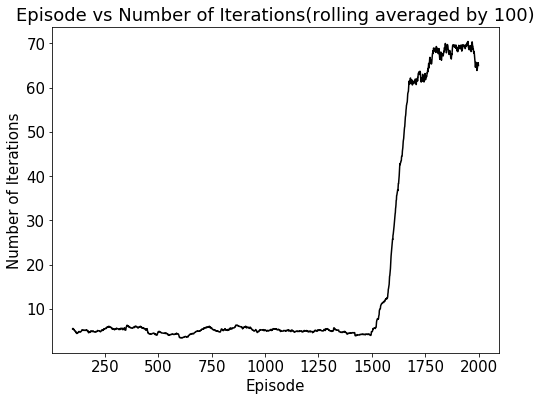

In [163]:
plt.figure(figsize=(8,6))
plt.plot(pd.Series(iterations).rolling(100, min_periods=100).mean(), 'k')
plt.xlabel("Episode")
plt.ylabel("Number of Iterations")
plt.title("Episode vs Number of Iterations(rolling averaged by 100)")
plt.savefig('../plots/Frozen Lake Q iterations.png')
